# Imports and constants

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

mpl.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_colwidth", None)

PRIMARY_COLOR = "#C71918" # Main color used for some plots.
ROUND = 2 # Number of decimals to round to.

PROJECT_NAME = "sweethome3d"
LABELS = ["Controller", "Coordinator", "Information Holder", "Interfacer", "Service Provider", "Structurer"]
LABELS_ABBREVIATED = ["CT", "CO", "IH", "IT", "SP", "ST"]

RANDOM_SEED = 41 # RNG for random_state option.
K = 10 # Number of folds to
cv = StratifiedKFold(n_splits=K) # Cross-validation strategy.

# Helper methods.

#### Load data and transform categorical features.

In [40]:
def get_one_hot_encoding(data):
    cat_publicity = pd.get_dummies(data, prefix=['classPublicity'])
    cat_publicity = cast_to_categorical(cat_publicity)
    return cat_publicity

def cast_to_categorical(data):
    non_categorical= data.select_dtypes(include=['object', 'bool', 'uint8']).copy()
    column_list = non_categorical.columns.values.tolist()
    for column in column_list:
        data[column] = data[column].astype('category')
    return data

def cast_to_num(data):
    categorical= data.select_dtypes(include=['category']).copy()
    column_list = categorical.columns.values.tolist()
    for column in column_list:
        data[column] = data[column].astype('int64')
    return data

def load_data(data_path: str, drop_cols: list, cat_features: list = None, filter_name: str = None):
    raw_data = pd.read_csv(data_path)
    
    if not filter_name is None:
        raw_data = raw_data[raw_data["fullpathname"].str.contains(filter_name, case=False)]
    
    X = raw_data.drop(columns=drop_cols)
    if not cat_features is None:
        X = get_one_hot_encoding(X)
        X = cast_to_num(X)
    
    y = raw_data["label"]
    
    return X, y

#### Define training pipeline.

In [18]:
def get_pipeline(resampler: str, model: str):
    resampler = resampler.lower()
    model = model.lower()
    pipe = Pipeline(steps=[])
    
    if model == "mnb": # MNB doesn't work with negative values, so replace the -1's with 0's.
        pipe.steps.append(["imputer", SimpleImputer(missing_values=-1, fill_value=0, strategy="constant")])
    
    if resampler == "smote":
        pipe.steps.append(["resampler", SMOTE(random_state=RANDOM_SEED)])
        
    if model == "rf":
        pipe.steps.append(["clf", RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)])
    elif model == "svm":
        pipe.steps.append(["clf", SVC(kernel='linear', C=1, random_state=RANDOM_SEED)])
    elif model == "mnb":
        pipe.steps.append(["clf", MultinomialNB()])
    
    return pipe

#### Miscellaneous

In [6]:
def format_std(score, std):
    return "{:.2f}±{:.2f}".format(score, std)

def print_scores(scores_dict: dict):
    print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("CONFIG", "PREC", "REC", "F1", "MCC"))
    for alg, score in scores_dict.items():
        print("{:<20} {:<10} {:<10} {:<10} {:<10}".
              format(alg, format_std(score['prec'], score['prec_std']), 
                                     format_std(score['rec'], score['rec_std']), 
                                     format_std(score['f1'], score['f1_std']), 
                                     format_std(score['mcc'], score['mcc_std'])))

def convert_name(class_name):
    class_name = class_name.removeprefix("\src\\")
    class_name = class_name.removesuffix(".java")
    class_name = class_name.replace(".", "$")
    class_name = class_name.replace("\\", ".")

    return class_name

# Loading the data

#### Our own dataset (i.e. the dynamic features).

In [38]:
# Our own dataset (i.e. based on dynamic features) - 501 classes.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL_v2.csv"
drop_cols = ["className", "label"]
X, y = load_data(data_path, drop_cols)

# Dataset of the paper (i.e. based on static features, but only classes that are from SweetHome3D) - 546 classes.
data_path_paper_546 = "/Users/mboopi/Documents/GitHub/jss_role_experiments/dataset/three/three-cases-20190301.csv"
drop_cols_paper = ["index", "fullpathname", "classname", "label"]
cat_features = ["classPublicity"]
X_paper_546, y_paper_546 = load_data(data_path_paper_546, drop_cols_paper, cat_features, filter_name=PROJECT_NAME)

# Dataset of the paper (but only the classes that are present in both of the previous datasets) - 501 classes.
raw_data = pd.read_csv(data_path) # Our own dataset.
raw_data_paper = pd.read_csv(data_path_paper_546) # Dataset of paper.
raw_data_paper = raw_data_paper[raw_data_paper["fullpathname"].str.contains(PROJECT_NAME, case=False)]
raw_data_paper["className"] = raw_data_paper["fullpathname"].apply(lambda x: convert_name(x))

merged_data = pd.merge(raw_data["className"], raw_data_paper, on="className", how="inner")
y_paper_501 = merged_data["label"]
X_paper_501 = merged_data.drop(columns=["className", "index", "fullpathname", "label", "classname"])
X_paper_501 = get_one_hot_encoding(X_paper_501)
X_paper_501 = cast_to_num(X_paper_501)

# Combined dataset (i.e. both dynamic + static features) - 501 classes.
combined_data = pd.merge(raw_data, raw_data_paper, on="className", how="inner")
y_combined = combined_data["label_x"]
y_combined.name = "label"
X_combined = combined_data.drop(columns=["className", "index", "fullpathname", "label_y", "label_x", "classname"])
X_combined = get_one_hot_encoding(X_combined)
X_combined = cast_to_num(X_combined)

# Exploratory code

#### Data processing

In [27]:
# Load the data.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL_v2.csv"
data_path2 = "/Users/mboopi/Documents/KY/CSE_Y3/Q2:3/Thesis/JSS2019_SCAM_ReplicationPackage/Classification Experiment/dataset/multi-class classification/three-cases-20190301.csv"
raw_data = pd.read_csv(data_path)
raw_data2 = pd.read_csv(data_path2)

# Drop the class names and split data into features and labels.
X = raw_data.drop(columns=["className", "label"])
y = raw_data["label"]
X_2 = raw_data2.drop(columns=["index", "fullpathname", "classname", "label"])
y_2 = raw_data2["label"]

#### Data exploration and validation
The dataset based on dynamic features cover 501 out of the 546 classes, used by the paper.
For each RS, we miss the following number of classes:
- IH: 11
- SP: 30
- IT: 3
- CT: 0
- ST: 1
- CO: 0

Information Holder    216
Service Provider      129
Interfacer             60
Controller             38
Structurer             37
Coordinator            21
Name: label, dtype: int64


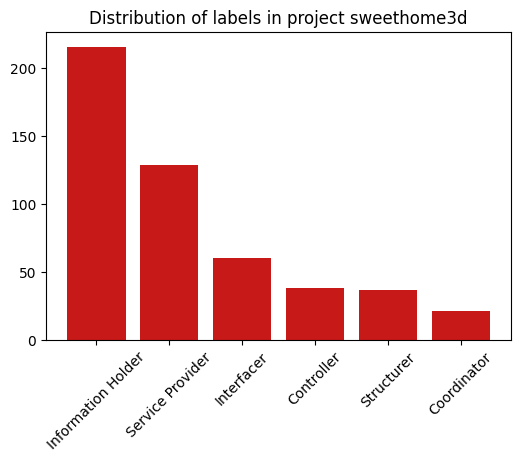

Average correlation of each feature, to any other feature:
numIntCalls                        0.396755
numExtCalls                        0.397351
ratioInternalExternal              0.045086
numIncomingCalls                   0.325873
numOutgoingCalls                   0.403598
ratioIncomingOutgoing              0.089829
numUniqueIncomingCalls             0.277120
numUniqueOutgoingCalls             0.240528
incomingCallsInside                0.301732
incomingCallsOutside               0.153451
outgoingCallsInside                0.339573
outgoingCallsOutside               0.386581
incomingCallsRatioInsideOutside    0.166988
outgoingCallsRatioInsideOutside    0.026650
numObjectsCreated                  0.329028
percObjectCreation                -0.019918
numLeaves                          0.303337
percLeaves                         0.023753
avgExecTime                        0.001198
avgDepth                          -0.022785
numObjectsTotal                    0.145703
numObjectsDealloc

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


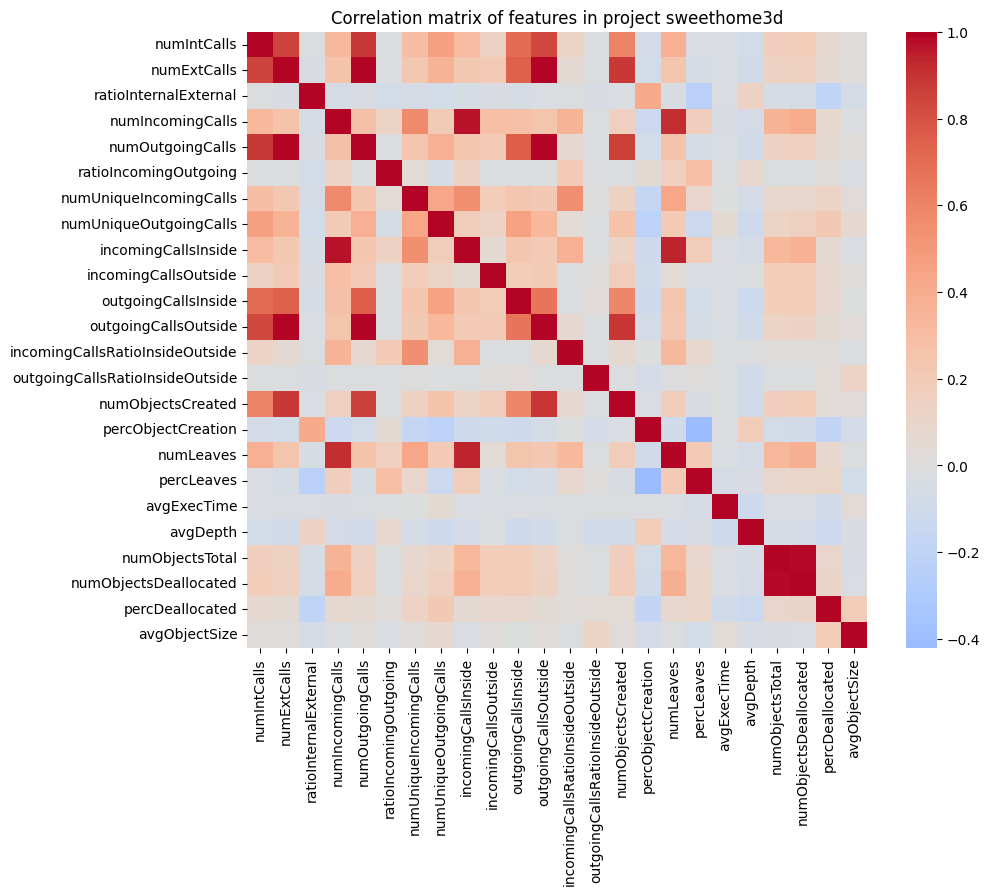

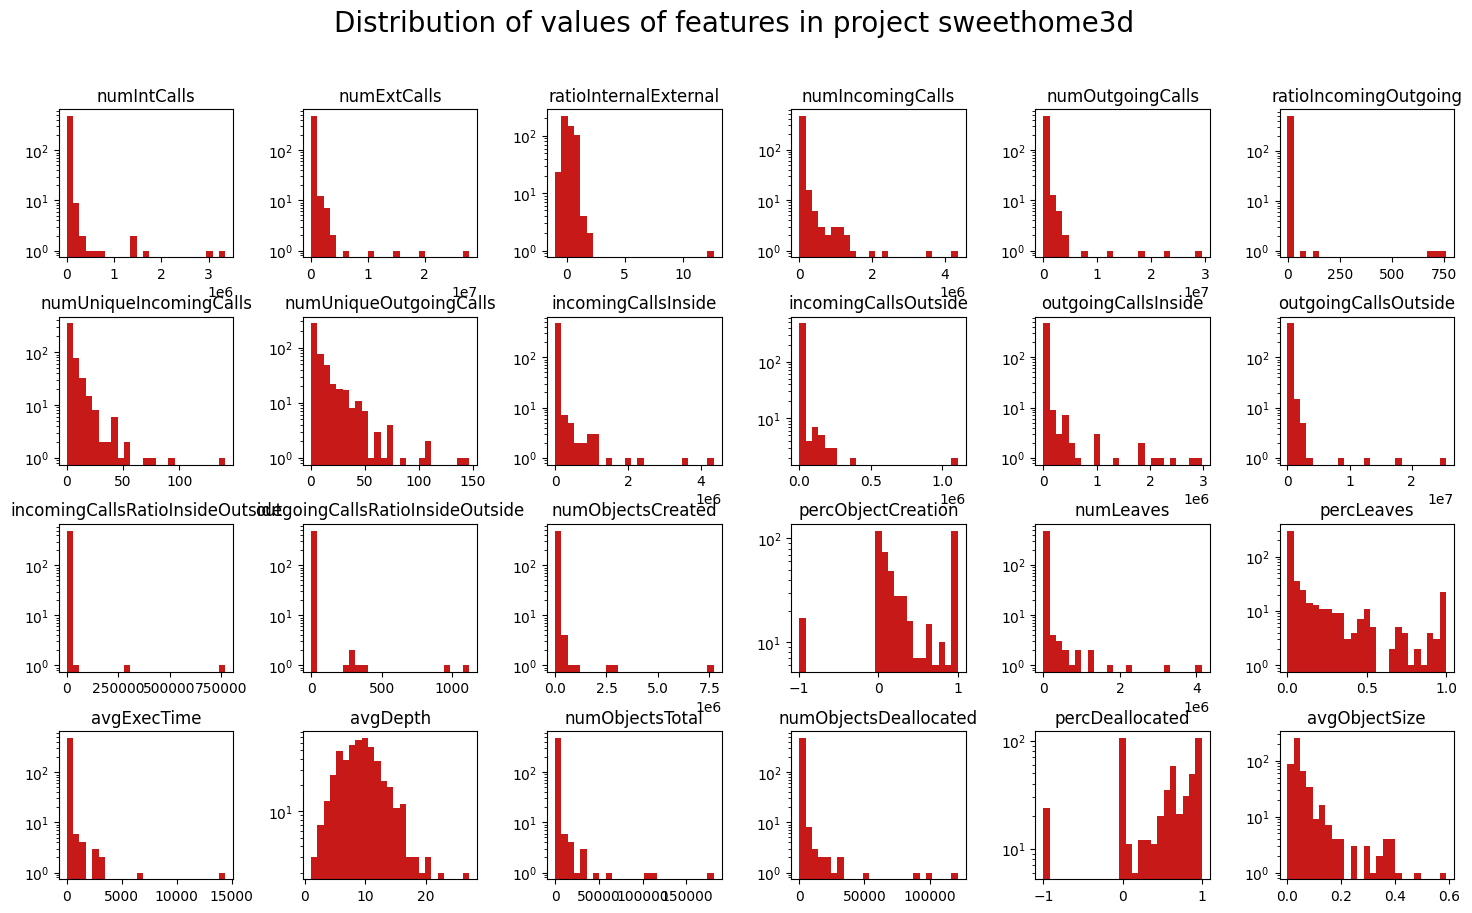

In [28]:
# Check distribution of the labels in the dataset.
frequencies = y.value_counts()
print(frequencies)

plt.bar(frequencies.index, frequencies.values, color=PRIMARY_COLOR)
plt.title(f"Distribution of labels in project {PROJECT_NAME}")
plt.xticks(rotation=45)
plt.show()


# Check feature correlation by computing a correlation matrix that shows the Pearson correlation coefficient (r) between each pair of features. 
# This r is a measure of the linear relationship between 2 variables. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), 
# with 0 indicating no correlation.
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Compute the average value of r by converting df to np array.
                                                      # Compute the average only on the upper triangle of the matrix, excluding diagonals.
avg_r = np.mean(corr_matrix[mask]) 
print("Average correlation of each feature, to any other feature:")
print(avg_r)

mpl.rcParams["figure.figsize"] = (10, 8) # Otherwise some rows will be missing from the plot.
sns.heatmap(corr_matrix, cmap="coolwarm", center=0);
plt.title(f"Correlation matrix of features in project {PROJECT_NAME}")
mpl.rcParams["figure.figsize"] = (6, 4)

# Plot distribution of each feature.
columns = X.columns.tolist()
num_features = X.shape[1]

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10))
fig.suptitle(f"Distribution of values of features in project {PROJECT_NAME}", fontsize=20)
axs = axs.flatten()
for i in range(num_features):
    col_name = columns[i]
    axs[i].hist(X[col_name], bins=25, color=PRIMARY_COLOR, log=True)
    axs[i].set_title(col_name)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  


# Some extra sanity checks to validate the values of our features.
# rounding = 3
# for feature in columns:
#     min_val = X[feature].min().round(rounding)
#     max_val = X[feature].max().round(rounding)
#     avg_val = X[feature].mean().round(rounding)
#     std_val = X[feature].std().round(rounding)
#     med_val = X[feature].median().round(rounding)
#     print(f"{feature}: MIN - MAX - MEAN - STD - MEDIAN")
#     print(f"{min_val} - {max_val} - {avg_val} - {std_val} - {med_val}")
#     print("\n")
    

#### Training

In [29]:
smote = ADASYN(random_state=RANDOM_SEED)

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
# rf = svm.SVC(kernel="rbf", C=1)
# rf = LinearSVC(C=1, n_jobs=-1)

# X = X.replace(-1, 0)
# rf = naive_bayes.MultinomialNB()

scaler = Normalizer()


skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

precision_scores = np.zeros(K)
recall_scores = np.zeros(K)
f1_scores = np.zeros(K)
mcc_scores = np.zeros(K)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index] 
    y_test = y.iloc[test_index]
    
    # X_train, y_train = smote.fit_resample(X_train, y_train)
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
    

    rf.fit(X_train, y_train)
    
    # Get feature importances
    # importances = rf.feature_importances_

    # Print feature importances
#     for feature, importance in zip(rf.feature_names_in_, importances):
#         print(f'{feature}: {importance}')
    
    y_pred = rf.predict(X_test)
    # print("Unique predictions: ", np.unique(y_pred))
    # print("Unique training classes in split: ", y_train.value_counts())
    # print("Unique test classes in split: ", y_test.value_counts())
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=FEATURE_ABBREV, labels=FEATURE_NAMES)
    
    
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    precision_scores[i] = precision
    recall_scores[i] = recall
    f1_scores[i] = f1
    mcc_scores[i] = mcc

    # print("%0.2f\t%0.2f\t%0.2f\t%0.2f"% (precision, recall, f1, mcc))

print("===AVG, STD===")
print("Precision: ", np.mean(precision_scores), np.std(precision_scores))
print("Recall: ", np.mean(recall_scores), np.std(recall_scores))
print("F1: ", np.mean(f1_scores), np.std(f1_scores))
print("MCC: ", np.mean(mcc_scores), np.std(mcc_scores))

NameError: name 'ADASYN' is not defined

# Multi-class classification

#### Define method for training based on pipeline.

In [13]:
def train_pipe(pipeline, X, y, cv_strat, title):
    precision_scores = np.zeros(K)
    recall_scores = np.zeros(K)
    f1_scores = np.zeros(K)
    mcc_scores = np.zeros(K)
    
    acc_per_class = {}
    for label in LABELS:
        acc_per_class[label] = 0
    
    y_test_all = [] # For determining the confusion matrix over all folds.
    y_pred_all = []
    
    print(f"====== CONFIG: {title} ======")
    
    for i, (train_index, test_index) in enumerate(cv_strat.split(X, y)):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index] 
        y_test = y.iloc[test_index]
        
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
        precision_scores[i] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall_scores[i] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1_scores[i] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        mcc_scores[i] = matthews_corrcoef(y_test, y_pred)
        
        for index, label in enumerate(LABELS):
            class_acc = np.mean(y_pred[y_test == label] == label)
            acc_per_class[label] += class_acc

    print("AVERAGE ACCURACY PER CLASS:")
    col_string = f""
    accuracy_string = f""
    for key, value in acc_per_class.items():
        col_string += f"{key:<{20}}"
        accuracy_string += f"{(value / K).round(ROUND):<{20}}"
    print(col_string)
    print(accuracy_string)
    
    score = {"prec": precision_scores.mean().round(ROUND), "prec_std": precision_scores.std().round(ROUND),
             "rec": recall_scores.mean().round(ROUND), "rec_std": recall_scores.std().round(ROUND),
             "f1": f1_scores.mean().round(ROUND), "f1_std": f1_scores.std().round(ROUND),
             "mcc": mcc_scores.mean().round(ROUND), "mcc_std": mcc_scores.std().round(ROUND)}
    
    print("\n")
    print("{:<10} {:<10} {:<10} {:<10}".format("PREC", "REC", "F1", "MCC"))
    print("{:<10} {:<10} {:<10} {:<10}".format(format_std(score['prec'], score['prec_std']), 
                                     format_std(score['rec'], score['rec_std']), 
                                     format_std(score['f1'], score['f1_std']), 
                                     format_std(score['mcc'], score['mcc_std'])))
    
    ConfusionMatrixDisplay.from_predictions(y_test_all, y_pred_all, display_labels=LABELS_ABBREVIATED, labels=LABELS)
    plt.show()

#### Train models based on our own dataset (i.e. the dynamic features).

====== CONFIG: dynamic-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.52                0.0                 0.83                0.75                0.72                0.09                


PREC       REC        F1         MCC       
0.62±0.08  0.68±0.07  0.64±0.08  0.55±0.09 


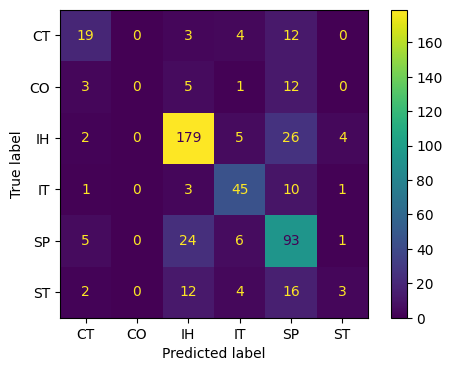

====== CONFIG: dynamic-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.54                0.1                 0.77                0.72                0.63                0.25                


PREC       REC        F1         MCC       
0.68±0.10  0.64±0.09  0.65±0.10  0.52±0.12 


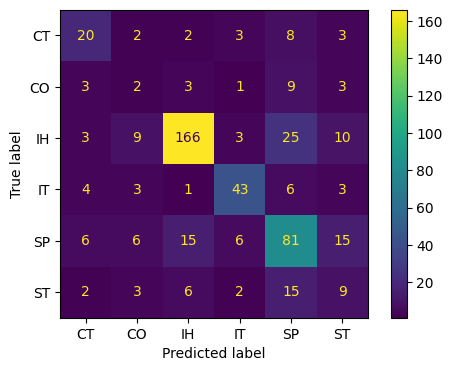

In [19]:
# scores_dynamic["svm"] = train_pipe(get_pipeline("standard", "", "svm"), X, y, cv)
# scores_dynamic["svm-smote"] = train_pipe(get_pipeline("standard", "smote", "svm"), X, y, cv)
# scores_dynamic["mnb"] = train_pipe(get_pipeline("normalizer", "", "mnb"), X, y, cv)
# scores_dynamic["mnb-smote"] = train_pipe(get_pipeline("normalizer", "smote", "mnb"), X, y, cv)
train_pipe(get_pipeline("", "rf"), X, y, cv, title="dynamic-rf")
train_pipe(get_pipeline("smote", "rf"), X, y, cv, title="dynamic-rf-smote")

#### Train models based on the dataset of the paper (i.e. the static features), on 546 classes of SweetHome3D.

====== CONFIG: static_546-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.67                0.0                 0.87                0.7                 0.8                 0.25                


PREC       REC        F1         MCC       
0.71±0.08  0.74±0.07  0.71±0.07  0.63±0.10 


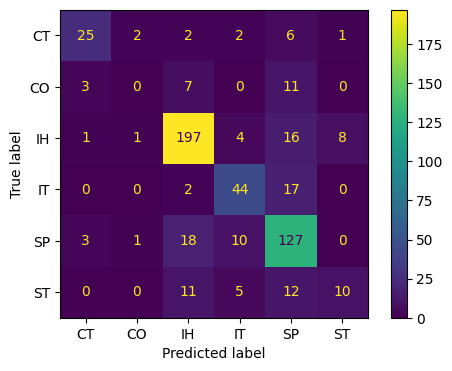

====== CONFIG: static_546-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.71                0.1                 0.79                0.72                0.71                0.35                


PREC       REC        F1         MCC       
0.72±0.06  0.69±0.08  0.69±0.07  0.59±0.10 


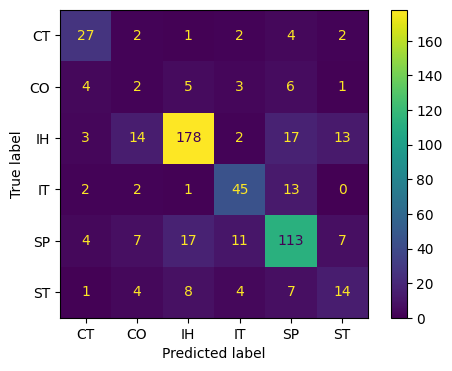

In [21]:
# scores_paper["svm"] = train_pipe(get_pipeline("standard", "", "svm"), X_paper, y_paper, cv)
# scores_paper["svm-smote"] = train_pipe(get_pipeline("standard", "smote", "svm"), X_paper, y_paper, cv)
# scores_paper["mnb"] = train_pipe(get_pipeline("normalizer", "", "mnb"), X_paper, y_paper, cv)
# scores_paper["mnb-smote"] = train_pipe(get_pipeline("normalizer", "smote", "mnb"), X_paper, y_paper, cv)
train_pipe(get_pipeline("", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf")
train_pipe(get_pipeline("smote", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf-smote")

#### Train models based on dataset of the paper, but only the classes there are also present in our own dataset, 501 classes of SweetHome3D.

====== CONFIG: static_501-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.72                0.0                 0.89                0.72                0.8                 0.24                


PREC       REC        F1         MCC       
0.71±0.06  0.75±0.05  0.71±0.06  0.65±0.07 


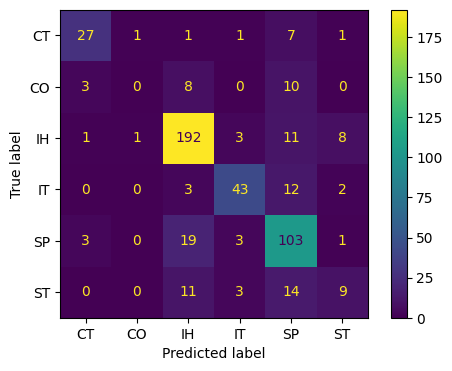

====== CONFIG: static_501-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.72                0.03                0.83                0.72                0.7                 0.27                


PREC       REC        F1         MCC       
0.72±0.07  0.70±0.07  0.70±0.07  0.60±0.08 


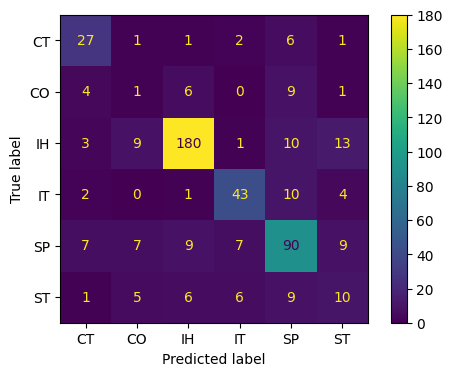

In [22]:
# scores_merged["svm"] = train_pipe(get_pipeline("standard", "", "svm"), X_merged, y_merged, cv)
# scores_merged["svm-smote"] = train_pipe(get_pipeline("standard", "smote", "svm"), X_merged, y_merged, cv)
# scores_merged["mnb"] = train_pipe(get_pipeline("normalizer", "", "mnb"), X_merged, y_merged, cv)
# scores_merged["mnb-smote"] = train_pipe(get_pipeline("normalizer", "smote", "mnb"), X_merged, y_merged, cv)
train_pipe(get_pipeline("", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf")
train_pipe(get_pipeline("smote", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf-smote")

#### Train models based on the static and dynamic features combined, 501 classes of SweetHome3D.

====== CONFIG: combined-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.72                0.0                 0.9                 0.8                 0.8                 0.14                


PREC       REC        F1         MCC       
0.71±0.05  0.75±0.04  0.72±0.05  0.66±0.05 


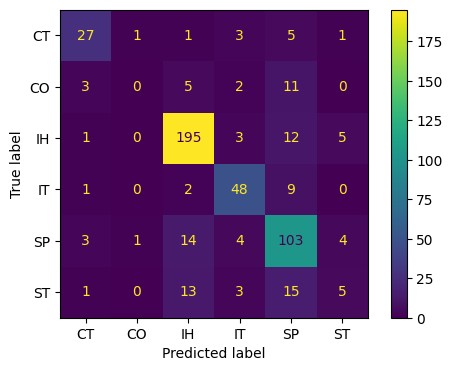

====== CONFIG: combined-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.72                0.05                0.8                 0.77                0.67                0.34                


PREC       REC        F1         MCC       
0.71±0.08  0.69±0.07  0.69±0.07  0.58±0.09 


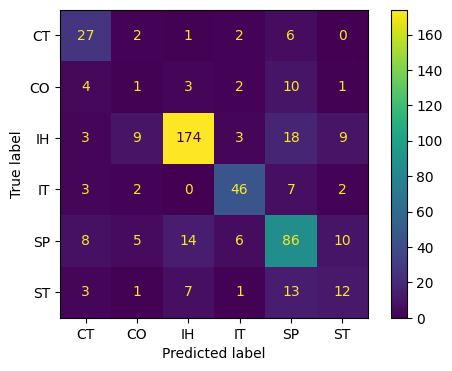

In [49]:
# scores_combined["svm"] = train_pipe(get_pipeline("standard", "", "svm"), X_combined, y_combined, cv)
# scores_combined["svm-smote"] = train_pipe(get_pipeline("standard", "smote", "svm"), X_combined, y_combined, cv)
# scores_combined["mnb"] = train_pipe(get_pipeline("normalizer", "", "mnb"), X_combined, y_combined, cv)
# scores_combined["mnb-smote"] = train_pipe(get_pipeline("normalizer", "smote", "mnb"), X_combined, y_combined, cv)
train_pipe(get_pipeline("", "rf"), X_combined, y_combined, cv, title="combined-rf")
train_pipe(get_pipeline("smote", "rf"), X_combined, y_combined, cv, title="combined-rf-smote")

# Binary classification (single role 1-vs-all)

#### Define method to extract binary datasets and training method adjusted for binary classification.

In [92]:
def extract_binary_dataset(role: str, features, labels):
    dataset = pd.concat([features, labels], axis=1)
    dataset.loc[dataset["label"] != role, "label"] = "Other"
    new_labels = dataset["label"]
    
    return features, new_labels

def train_pipe_binary(pipeline, X, y, cv_strat, title):
    print("{:<40} {:<10} {:<10} {:<10} {:<10}".format("", "PREC", "REC", "F1", "MCC"))
    
    for role in LABELS:
        X_bin, y_bin = extract_binary_dataset(role, X, y)
        
        title_new = title + "_" + role

        precision_scores = np.zeros(K)
        recall_scores = np.zeros(K)
        f1_scores = np.zeros(K)
        mcc_scores = np.zeros(K)

        for i, (train_index, test_index) in enumerate(cv_strat.split(X_bin, y_bin)):
            X_train = X_bin.iloc[train_index]
            y_train = y_bin.iloc[train_index]
            X_test = X_bin.iloc[test_index] 
            y_test = y_bin.iloc[test_index]

            clf = pipeline.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            precision_scores[i] = precision_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            recall_scores[i] = recall_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            f1_scores[i] = f1_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            mcc_scores[i] = matthews_corrcoef(y_test, y_pred)

        score = {"prec": precision_scores.mean().round(ROUND), "prec_std": precision_scores.std().round(ROUND),
                 "rec": recall_scores.mean().round(ROUND), "rec_std": recall_scores.std().round(ROUND),
                 "f1": f1_scores.mean().round(ROUND), "f1_std": f1_scores.std().round(ROUND),
                 "mcc": mcc_scores.mean().round(ROUND), "mcc_std": mcc_scores.std().round(ROUND)}
        
        print("{:<40} {:<10} {:<10} {:<10} {:<10}".format(title_new,
                                         format_std(score['prec'], score['prec_std']), 
                                         format_std(score['rec'], score['rec_std']), 
                                         format_std(score['f1'], score['f1_std']), 
                                         format_std(score['mcc'], score['mcc_std'])))

#### Train models based on our own dataset (i.e. the dynamic features).

In [ ]:
train_pipe_binary(get_pipeline("", "rf"), X, y, cv, title="dynamic-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X, y, cv, title="dynamic-rf-smote")

                                    PREC       REC        F1         MCC       
dynamic-rf_Controller               0.62±0.43  0.30±0.23  0.39±0.28  0.41±0.29 
dynamic-rf_Coordinator              0.00±0.00  0.00±0.00  0.00±0.00  -0.00±0.01
dynamic-rf_Information Holder       0.87±0.11  0.72±0.09  0.78±0.08  0.66±0.13 
dynamic-rf_Interfacer               0.91±0.15  0.52±0.16  0.64±0.14  0.65±0.14 
dynamic-rf_Service Provider         0.73±0.18  0.44±0.13  0.54±0.13  0.45±0.17 
dynamic-rf_Structurer               0.05±0.15  0.02±0.08  0.03±0.10  0.03±0.10 
                                    PREC       REC        F1         MCC       
dynamic-rf-smote_Controller         0.52±0.34  0.47±0.30  0.47±0.27  0.45±0.29 
dynamic-rf-smote_Coordinator        0.03±0.10  0.05±0.15  0.04±0.12  0.01±0.12 
dynamic-rf-smote_Information Holder 0.83±0.11  0.74±0.09  0.77±0.07  0.63±0.14 
dynamic-rf-smote_Interfacer         0.81±0.19  0.68±0.16  0.72±0.15  0.70±0.16 
dynamic-rf-smote_Service Provider   0.59

#### Train models based on the dataset of the paper (i.e. the static features), on 546 classes of SweetHome3D.

In [93]:
train_pipe_binary(get_pipeline("", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf-smote")

                                         PREC       REC        F1         MCC       
static_546-rf_Controller                 0.84±0.31  0.65±0.36  0.69±0.32  0.70±0.31 
static_546-rf_Coordinator                0.00±0.00  0.00±0.00  0.00±0.00  0.00±0.00 
static_546-rf_Information Holder         0.88±0.15  0.82±0.13  0.83±0.09  0.74±0.14 
static_546-rf_Interfacer                 0.80±0.23  0.49±0.19  0.57±0.17  0.57±0.17 
static_546-rf_Service Provider           0.77±0.16  0.65±0.13  0.69±0.11  0.59±0.16 
static_546-rf_Structurer                 0.40±0.49  0.18±0.25  0.23±0.31  0.25±0.33 
                                         PREC       REC        F1         MCC       
static_546-rf-smote_Controller           0.61±0.26  0.72±0.34  0.65±0.28  0.64±0.30 
static_546-rf-smote_Coordinator          0.02±0.05  0.05±0.15  0.02±0.08  -0.01±0.09
static_546-rf-smote_Information Holder   0.87±0.14  0.85±0.11  0.85±0.08  0.75±0.15 
static_546-rf-smote_Interfacer           0.73±0.22  0.73±0.16  0.

#### Train models based on dataset of the paper, but only the classes there are also present in our own dataset, 501 classes of SweetHome3D.

In [90]:
train_pipe_binary(get_pipeline("", "rf"), X_paper_501, y_paper_501, cv, title="dynamic-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_paper_501, y_paper_501, cv, title="dynamic-rf-smote")

                                    PREC       REC        F1         MCC       
dynamic-rf_Controller               0.83±0.31  0.67±0.35  0.69±0.32  0.71±0.30 
dynamic-rf_Coordinator              0.00±0.00  0.00±0.00  0.00±0.00  -0.00±0.01
dynamic-rf_Information Holder       0.90±0.13  0.84±0.12  0.86±0.08  0.77±0.14 
dynamic-rf_Interfacer               0.83±0.26  0.50±0.17  0.59±0.16  0.59±0.17 
dynamic-rf_Service Provider         0.76±0.18  0.58±0.17  0.65±0.15  0.56±0.19 
dynamic-rf_Structurer               0.32±0.45  0.17±0.23  0.21±0.29  0.21±0.31 
                                    PREC       REC        F1         MCC       
dynamic-rf-smote_Controller         0.52±0.19  0.72±0.32  0.59±0.23  0.57±0.25 
dynamic-rf-smote_Coordinator        0.05±0.15  0.03±0.10  0.04±0.12  -0.00±0.13
dynamic-rf-smote_Information Holder 0.91±0.14  0.84±0.12  0.86±0.09  0.77±0.16 
dynamic-rf-smote_Interfacer         0.72±0.23  0.78±0.18  0.72±0.19  0.70±0.20 
dynamic-rf-smote_Service Provider   0.69

#### Train models based on the static and dynamic features combined, 501 classes of SweetHome3D.

In [91]:
train_pipe_binary(get_pipeline("", "rf"), X_combined, y_combined, cv, title="dynamic-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_combined, y_combined, cv, title="dynamic-rf-smote")

                                    PREC       REC        F1         MCC       
dynamic-rf_Controller               0.74±0.39  0.57±0.35  0.61±0.34  0.62±0.33 
dynamic-rf_Coordinator              0.00±0.00  0.00±0.00  0.00±0.00  0.00±0.00 
dynamic-rf_Information Holder       0.89±0.12  0.80±0.11  0.83±0.08  0.73±0.14 
dynamic-rf_Interfacer               0.92±0.15  0.55±0.17  0.66±0.13  0.67±0.12 
dynamic-rf_Service Provider         0.79±0.16  0.51±0.15  0.60±0.14  0.53±0.15 
dynamic-rf_Structurer               0.00±0.00  0.00±0.00  0.00±0.00  -0.01±0.02
                                    PREC       REC        F1         MCC       
dynamic-rf-smote_Controller         0.68±0.32  0.67±0.32  0.64±0.28  0.64±0.29 
dynamic-rf-smote_Coordinator        0.10±0.30  0.05±0.15  0.07±0.20  0.04±0.22 
dynamic-rf-smote_Information Holder 0.88±0.12  0.81±0.10  0.84±0.08  0.73±0.15 
dynamic-rf-smote_Interfacer         0.83±0.18  0.68±0.14  0.74±0.15  0.72±0.16 
dynamic-rf-smote_Service Provider   0.69